
# Bayesian Inference for Individual-Level Estimates  
**Using Gaussian Priors**

**Objective:** Estimate the true latent value (e.g., hemoglobin level) for an individual based on:  
- Population-level data  
- Individual-level noisy observations  

---


## 1. Bayesian Framework

We model the individual's true value $ \mu_i $ using a prior and a likelihood:

### Assumptions

- **Prior (Population-level)**:  
  $$
  \mu_i \sim \mathcal{N}(\mu_0, \tau^2)
  $$

- **Likelihood (Individual-level Observations)**:  
  $$
  z_{ij} \mid \mu_i \sim \mathcal{N}(\mu_i, \sigma^2), \quad j = 1, \dots, n
  $$

Where:  
- $ \mu_i $: latent true value for individual $ i $  
- $ z_{ij} $: observed measurement  
- $ \mu_0, \tau^2 $: prior mean and variance  
- $ \sigma^2 $: measurement variance  

---

## 2. Synthetic Data Generation


In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import matplotlib.pyplot as plt

def generate_data(mu_intercept=10.0, beta_age=0.3, A=1.0, n=1000, seed=42):
    np.random.seed(seed)
    age = np.random.normal(50, 10, size=n)
    true_mu = mu_intercept + beta_age * age + np.random.normal(0, np.sqrt(A), size=n)
    obs_var = np.random.uniform(0.3, 1.0, size=n)
    observed = np.random.normal(true_mu, np.sqrt(obs_var))

    return pd.DataFrame({
        'individual': np.arange(n),
        'age': age,
        'true_mu': true_mu,
        'observed': observed,
        'obs_var': obs_var,
        'true_var': A
    })

df = generate_data(mu_intercept=0, beta_age=0.3, A=1.0)
display(df.head())

,individual,age,true_mu,observed,obs_var,true_var
0,0,54.967142,17.889498,18.327847,0.584975,1.0
1,1,48.617357,15.509841,14.459049,0.346207,1.0
2,2,56.476885,17.002696,16.737404,0.544174,1.0
3,3,65.230299,18.922153,19.107205,0.377699,1.0
4,4,47.658466,14.995763,15.166815,0.865765,1.0



---

## 3. Bayesian Update (Single Observation)

If we observe a single $ z \sim \mathcal{N}(\mu, 1) $ and have a prior $ \mu \sim \mathcal{N}(0, A) $, then:

- **Posterior**:
  $$
  \mu \mid z \sim \mathcal{N}(B z, B), \quad B = \frac{A}{A + 1}
  $$

This result shows *shrinkage*: the posterior mean pulls the observation toward the prior mean.

---

## 4. Bayesian Update (Multiple Observations)

- **Prior**: $ \mu \sim \mathcal{N}(\mu_0, \tau^2) $  
- **Likelihood**: $ z_i \mid \mu \sim \mathcal{N}(\mu, \sigma^2) $

- **Posterior**:  
  $$
  \mu \mid \mathbf{z} \sim \mathcal{N}(w \bar{z} + (1 - w)\mu_0,\; \left( \frac{1}{\tau^2} + \frac{n}{\sigma^2} \right)^{-1})
  $$  
  where $ w = \frac{n/\sigma^2}{n/\sigma^2 + 1/\tau^2} $

---

## 5. Empirical Bayes (Standard)


In [3]:
def empirical_bayes(observed, obs_var, mu0, tau2):
    w = tau2 / (tau2 + obs_var)
    post_mu = w * observed + (1 - w) * mu0
    post_var = (tau2 * obs_var) / (tau2 + obs_var)
    return post_mu, post_var, w

df['post_mu'], df['post_var'], df['w'] = empirical_bayes(df['observed'], df['obs_var'], mu0=14, tau2=2)
display(df.head())

,individual,age,true_mu,observed,obs_var,true_var,post_mu,post_var,w
0,0,54.967142,17.889498,18.327847,0.584975,1.0,17.348464,0.452596,0.773702
1,1,48.617357,15.509841,14.459049,0.346207,1.0,14.391311,0.295121,0.852440
2,2,56.476885,17.002696,16.737404,0.544174,1.0,16.151899,0.427781,0.786110
3,3,65.230299,18.922153,19.107205,0.377699,1.0,18.295923,0.317701,0.841149
4,4,47.658466,14.995763,15.166815,0.865765,1.0,14.814313,0.604212,0.697894


---

## 6. Covariate-Informed Prior (Extended Empirical Bayes)

Model the prior mean as a function of covariates:

$$
\mu_i \sim \mathcal{N}(\mathbf{x}_i^\top \beta, A), \quad z_i \sim \mathcal{N}(\mu_i, \sigma_i^2)
$$

- **Posterior Mean**:
  $$
  \hat{\mu}_i = \mathbf{x}_i^\top \beta + B_i (z_i - \mathbf{x}_i^\top \beta), \quad B_i = \frac{A}{A + \sigma_i^2}
  $$


In [6]:
def fit_linear_prior(df, covariates):
    X = df[covariates].values
    y = df['observed'].values
    model = LinearRegression().fit(X, y)
    df['prior_mu_cov'] = model.predict(X)
    return model, df

def covariate_bayes(df, A):
    B = A / (A + df['obs_var'])
    post_mu = df['prior_mu_cov'] + B * (df['observed'] - df['prior_mu_cov'])
    post_var = B * df['obs_var']
    return post_mu, post_var, B

model, df = fit_linear_prior(df, ['age'])
df['cov_post_mu'], df['cov_post_var'], df['B'] = covariate_bayes(df, A=1.0)
display(df.head())

,individual,age,true_mu,observed,obs_var,true_var,post_mu,post_var,w,prior_mu_cov,cov_post_mu,cov_post_var,B
0,0,54.967142,17.889498,18.327847,0.584975,1.0,17.348464,0.452596,0.773702,16.539781,17.667916,0.369075,0.630925
1,1,48.617357,15.509841,14.459049,0.346207,1.0,14.391311,0.295121,0.852440,14.654287,14.509259,0.257172,0.742828
2,2,56.476885,17.002696,16.737404,0.544174,1.0,16.151899,0.427781,0.786110,16.988081,16.825744,0.352405,0.647595
3,3,65.230299,18.922153,19.107205,0.377699,1.0,18.295923,0.317701,0.841149,19.587304,19.238825,0.274152,0.725848
4,4,47.658466,14.995763,15.166815,0.865765,1.0,14.814313,0.604212,0.697894,14.369556,14.796865,0.464027,0.535973


---
## 7. Confidence Intervals (Empirical Bayes)

### Known Variance $ A $:
$$
\mu_0 \sim \mathcal{N}(B z_0, B), \quad {95\% \: CI: } \:B z_0 \pm 1.96 \sqrt{B}
$$

### Unknown Variance $ A $:
$$
\hat{B} = 1 - \frac{N - 2}{\sum_{i=1}^N z_i^2}
$$

- Adjusted CI:
$$
\hat{B} z_0 \pm 1.96 \sqrt{ \hat{B} + \frac{2}{N - 2} z_0^2 (1 - \hat{B})^2 }
$$


In [8]:
def adjusted_variance(observed, w, n):
    return w + (2 / (n - 2)) * (observed ** 2) * (1 - w) ** 2

df['adj_post_var'] = adjusted_variance(df['observed'], df['w'], len(df))
df['adj_cov_post_var'] = adjusted_variance(df['observed'], df['B'], len(df))
display(df.head())

,individual,age,true_mu,observed,obs_var,true_var,post_mu,post_var,w,prior_mu_cov,cov_post_mu,cov_post_var,B,adj_post_var,adj_cov_post_var
0,0,54.967142,17.889498,18.327847,0.584975,1.0,17.348464,0.452596,0.773702,16.539781,17.667916,0.369075,0.630925,0.808175,0.722621
1,1,48.617357,15.509841,14.459049,0.346207,1.0,14.391311,0.295121,0.852440,14.654287,14.509259,0.257172,0.742828,0.861562,0.770537
2,2,56.476885,17.002696,16.737404,0.544174,1.0,16.151899,0.427781,0.786110,16.988081,16.825744,0.352405,0.647595,0.811793,0.717316
3,3,65.230299,18.922153,19.107205,0.377699,1.0,18.295923,0.317701,0.841149,19.587304,19.238825,0.274152,0.725848,0.859611,0.780837
4,4,47.658466,14.995763,15.166815,0.865765,1.0,14.814313,0.604212,0.697894,14.369556,14.796865,0.464027,0.535973,0.739967,0.635233


---

## 8. Visualization

In [12]:
df

,individual,age,true_mu,observed,obs_var,true_var,post_mu,post_var,w,prior_mu_cov,cov_post_mu,cov_post_var,B,adj_post_var,adj_cov_post_var
0,0,54.967142,17.889498,18.327847,0.584975,1.0,17.348464,0.452596,0.773702,16.539781,17.667916,0.369075,0.630925,0.808175,0.722621
1,1,48.617357,15.509841,14.459049,0.346207,1.0,14.391311,0.295121,0.852440,14.654287,14.509259,0.257172,0.742828,0.861562,0.770537
2,2,56.476885,17.002696,16.737404,0.544174,1.0,16.151899,0.427781,0.786110,16.988081,16.825744,0.352405,0.647595,0.811793,0.717316
3,3,65.230299,18.922153,19.107205,0.377699,1.0,18.295923,0.317701,0.841149,19.587304,19.238825,0.274152,0.725848,0.859611,0.780837
4,4,47.658466,14.995763,15.166815,0.865765,1.0,14.814313,0.604212,0.697894,14.369556,14.796865,0.464027,0.535973,0.739967,0.635233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,47.188997,15.226849,14.923830,0.539852,1.0,14.727468,0.425105,0.787448,14.230153,14.680636,0.350587,0.649413,0.807612,0.704273
996,996,67.976865,20.366538,20.611251,0.905261,1.0,18.551226,0.623187,0.688406,20.402864,20.512239,0.475138,0.524862,0.771064,0.717060
997,997,56.408429,16.040654,15.886845,0.408448,1.0,15.566856,0.339179,0.830410,16.967754,16.200307,0.289998,0.710002,0.844957,0.752538
998,998,44.288210,13.123396,13.128110,0.357916,1.0,13.260457,0.303587,0.848207,13.368798,13.191550,0.263577,0.736423,0.856165,0.760418


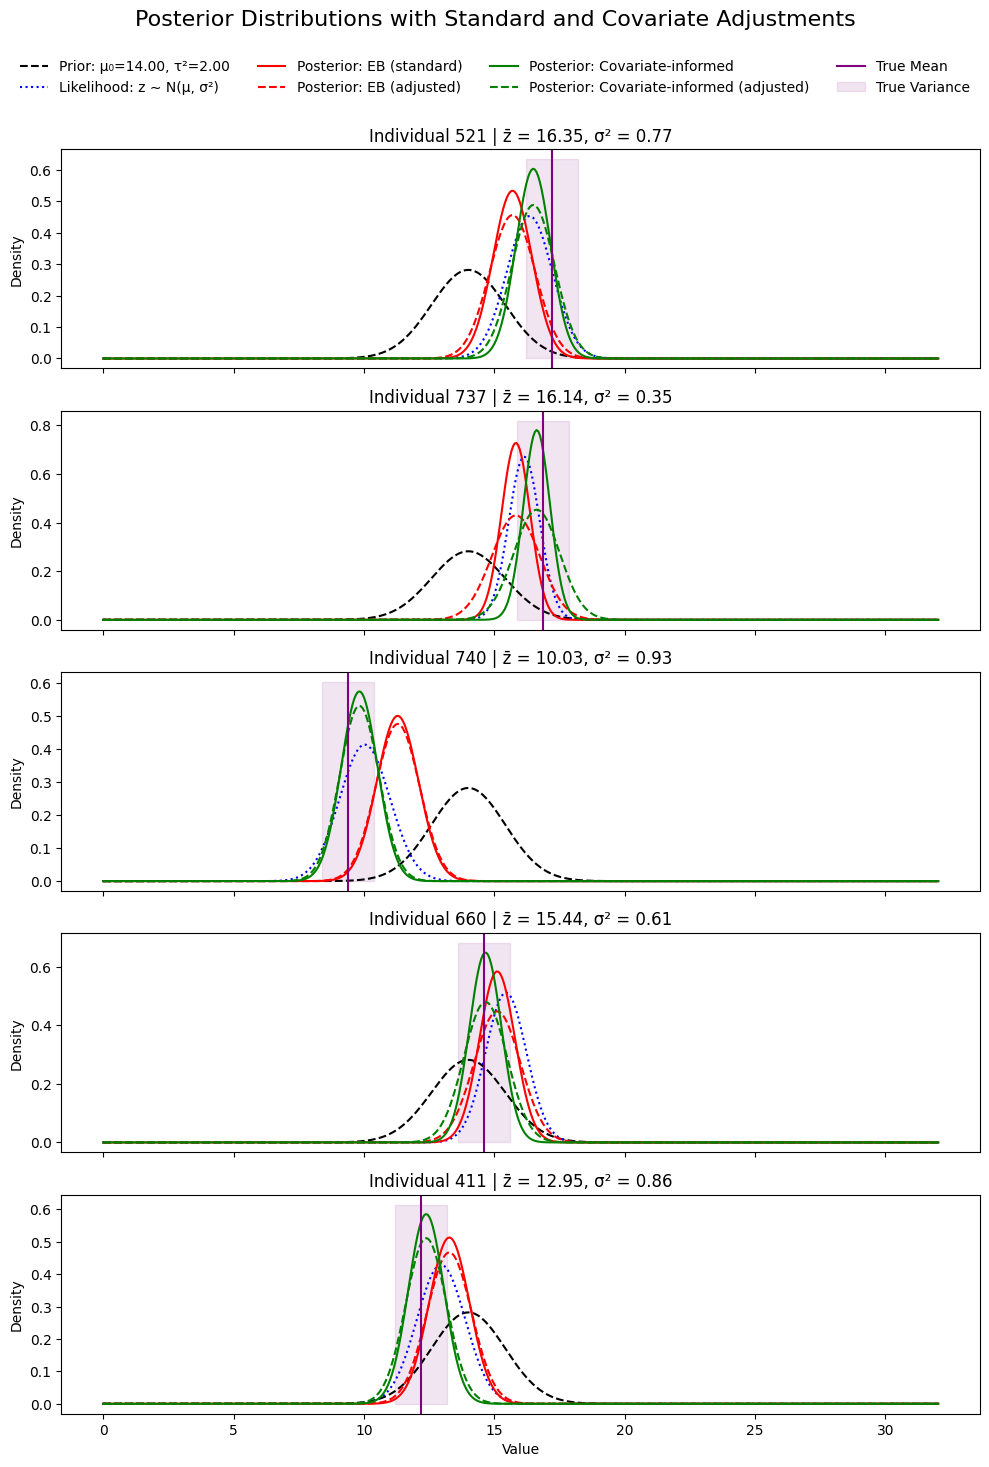

In [34]:
def plot_distributions(df, mu0, tau2, num_samples=5):
   
    samples = df.sample(num_samples, random_state=42)
    x_range = np.linspace(df['observed'].min() - 5, df['observed'].max() + 5, 500)
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 3 * num_samples), sharex=True)

    for i, (_, row) in enumerate(samples.iterrows()):
        ax = axes[i]

        # Plot prior
        ax.plot(x_range, norm.pdf(x_range, mu0, np.sqrt(tau2)), 'k--', label='Prior: μ₀=%.2f, τ²=%.2f' % (mu0, tau2))

        # Likelihood
        ax.plot(x_range, norm.pdf(x_range, row['observed'], np.sqrt(row['obs_var'])), 'b:', label='Likelihood: z ∼ N(μ, σ²)')

        # Empirical Bayes Posterior
        ax.plot(x_range, norm.pdf(x_range, row['post_mu'], np.sqrt(row['post_var'])), 'r-', label='Posterior: EB (standard)')

        # Adjusted Posterior
        ax.plot(x_range, norm.pdf(x_range, row['post_mu'], np.sqrt(row['adj_post_var'])), 'r--', label='Posterior: EB (adjusted)')

        # Covariate Posterior
        ax.plot(x_range, norm.pdf(x_range, row['cov_post_mu'], np.sqrt(row['cov_post_var'])), 'g-', label='Posterior: Covariate-informed')

        # Adjusted Covariate Posterior
        ax.plot(x_range, norm.pdf(x_range, row['cov_post_mu'], np.sqrt(row['adj_cov_post_var'])), 'g--', label='Posterior: Covariate-informed (adjusted)')

        # True value
        ax.axvline(row['true_mu'], color='purple', linestyle='-', label='True Mean')
        ax.fill_betweenx(np.linspace(0, ax.get_ylim()[1], 100),
                         row['true_mu'] - np.sqrt(row['true_var']),
                         row['true_mu'] + np.sqrt(row['true_var']),
                         color='purple', alpha=0.1, label='True Variance')

        # Axis title with sample info
        ax.set_title(f"Individual {int(row['individual'])} | z̄ = {row['observed']:.2f}, σ² = {row['obs_var']:.2f}")
        ax.set_ylabel("Density")
        if i == num_samples - 1:
            ax.set_xlabel("Value")

    # Shared legend and title (non-overlapping)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, frameon=False, bbox_to_anchor=(0.5, 1.00))
    fig.suptitle("Posterior Distributions with Standard and Covariate Adjustments", fontsize=16, y=1.025)
    plt.tight_layout(rect=[0, 0.05, 1, 0.98])
    plt.show()



plot_distributions(df, mu0=14, tau2=2)


---

## Summary

| Approach                     | Posterior Mean       | Posterior Variance                                     |
|-----------------------------|----------------------|---------------------------------------------------------|
| Known $ A $               | $ B z_0 $          | $ B $                                                 |
| Empirical Bayes (naive)     | $ \hat{B} z_0 $    | $ \hat{B} $                                           |
| Empirical Bayes (adjusted)  | $ \hat{B} z_0 $    | $ \hat{B} + \frac{2}{N - 2} z_0^2 (1 - \hat{B})^2 $   |
